In [18]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import json
from datetime import datetime
import re
import csv
from bs4 import BeautifulSoup

In [53]:
directory = 'data/financial_information'
onlyfiles = [f for f in listdir(directory) if isfile(join(directory, f))]
df = pd.DataFrame(onlyfiles, columns = ['Files'])
df['nr'] = df['Files'].str.split('.',expand=True)[0]
df.nr = df.nr.astype(int)
df.sort_values(["nr"], ignore_index=True, inplace=True)

In [107]:
names = pd.read_csv('data/main/companies.csv',sep='$')
df = df.merge(names, left_on='nr', right_on='Index')
df = df[['Files', 'nr', 'Name des Beihilfeempfängers']]
df

,Files,nr,Name des Beihilfeempfängers
0,1.json,1,K-motion GmbH & Co. KG
1,6.json,6,HGH Hotelgesellschaft mbH
2,7.json,7,Zillertal GmbH
3,8.json,8,Musikreisen Manufaktur GmbH
4,9.json,9,Junges Hotel Hamburg Betriebsgesellschaft mbH
...,...,...,...
33762,102841.json,102841,Agrargenossenschaft Geisenhain eG
33763,102842.json,102842,Möschlitzer Agrar GmbH
33764,102843.json,102843,LEVER Agrar-Aktiengesellschaft Heiligenstadt
33765,102859.json,102859,Schmiedefelder Alm GmbH


In [19]:
def return_table(grid, id, company):
    for idx, each_grid in enumerate(grid, start=0):
        grid_a = each_grid.find_all(string = re.compile("A. A"))
        grid_p = each_grid.find_all(string = re.compile("A. E"))
        if  grid_a and grid_p:
            #print(idx,'combined BS', id, company)
            return None #grid[idx]
            break
        if grid_a:
            #print(idx,'Aktiv')
            #aktiv = grid[idx]
            aktiv = idx
            #print(get_total(aktiv))
            continue
        if grid_p:
            #print(idx,'Passiv')
            #passiv = grid[idx]
            passiv = idx
            #print(get_total(passiv))
            continue
        else:
            #return None
            continue
    try:
        #return aktiv, passiv
        return [aktiv, passiv]
    except:
        #print("None", id, company)
        return None 
    
#return_table(grid, id='x', company='xy')

In [20]:
def get_KPI(a, p):
    
    kpi = {
  "current_ratio": "",
  "qick_ratio": "",
  "cash_ratio": "",
  "debt2equity_ratio": "",
  "debt2asset_ratio": "",
  "equity_ratio": ""}
    
    kpi["assets"] = to_float(p['Gesamt'])
    kpi["equity"] = to_float(p['Eigenkapital'])
    kpi['current_ratio'] = current_ratio(a,p)
    kpi['qick_ratio'] = qick_ratio(a,p)
    kpi['cash_ratio'] = cash_ratio(a,p)
    kpi['debt2equity_ratio'] = debt2equity_ratio(a,p)
    kpi['debt2asset_ratio'] = debt2asset_ratio(a,p)
    kpi['equity_ratio'] = equity_ratio(a,p)
    
    return kpi


def current_ratio(aktiv, passiv):
    current_a = aktiv['Umlaufvermögen']
    current_l = passiv['Verbindlichkeiten_kurz']
    if current_l == '' :
        current_l = passiv['Verbindlichkeiten']
    ratio = to_float(current_a) / to_float(current_l)
    return ratio

def qick_ratio(aktiv, passiv):
    current_a = to_float(aktiv['Umlaufvermögen'])
    inventory = to_float(aktiv['Vorräte'])
    current_l = to_float(passiv['Verbindlichkeiten_kurz'])
    if current_l == 0 :
        current_l = to_float(passiv['Verbindlichkeiten'])
    ratio = ( current_a - inventory )  / current_l
    return ratio

def cash_ratio(aktiv, passiv):
    cash = to_float(aktiv['Guthaben'])
    current_l = to_float(passiv['Verbindlichkeiten_kurz'])
    if current_l == 0 :
        current_l = to_float(passiv['Verbindlichkeiten'])
    ratio = cash / current_l
    return ratio

def debt2equity_ratio(aktiv, passiv):
    liabilities = to_float(passiv['Verbindlichkeiten'])
    provisions = to_float(passiv['Rückstellungen'])
    accruals = to_float(passiv['Rechnungsabgrenzungsposten'])
    debt = liabilities + provisions + accruals
    equity = to_float(passiv['Eigenkapital'])
    ratio = debt / equity
    return ratio

def debt2asset_ratio(aktiv, passiv):
    liabilities = to_float(passiv['Verbindlichkeiten'])
    provisions = to_float(passiv['Rückstellungen'])
    accruals = to_float(passiv['Rechnungsabgrenzungsposten'])
    debt = liabilities + provisions + accruals
    total = to_float(passiv['Gesamt'])
    ratio = debt / total
    return ratio

def equity_ratio(aktiv, passiv):
    equity = to_float(passiv['Eigenkapital'])
    total = to_float(passiv['Gesamt'])
    ratio = equity / total
    return ratio

def to_float(a):
    a = a.replace('.','').replace(',','.')
    if a == '':
        a = 0
    return float(a) 

In [21]:
def aktiva_items(data):
    item_aktiva = {
  "Gesamt": "",
  "Anlagevermögen": "",
  "Umlaufvermögen": "",
  "Vorräte": "",
  "Guthaben": ""}
    
    for section in data.find_all('tbody'):
        last_row = section.find_all('tr')[-1:]
        item_aktiva["Gesamt"] = last_row[0].find_all('td')[1].text.strip()

        for line in section.find_all('tr')[:-1]:
            cell_data = []
            for idx, cell in enumerate(line.find_all('td'), start=1):
                cell = cell.text
                if idx == 1:
                    name = cell.split(" ")[1].strip()
                if idx == 2 and "anlagevermögen" in name.lower():
                    item_aktiva["Anlagevermögen"] = cell
                if idx == 2 and "umlaufvermögen" in name.lower():
                    item_aktiva["Umlaufvermögen"] = cell
                if idx == 2 and "vorräte" in name.lower():
                    item_aktiva["Vorräte"] = cell
                if idx == 2 and re.search(r'(kassen|guthaben)', name.lower()):
                    item_aktiva["Guthaben"] = cell
    return(item_aktiva)

def passiva_items(data):
    item_passiva = {
  "Gesamt": "",
  "Eigenkapital": "",
  "Rückstellungen": "",
  "Rechnungsabgrenzungsposten": "",
  "Verbindlichkeiten": "",
  "Verbindlichkeiten_kurz": ""}
    
    for section in data.find_all('tbody'):
        last_row = section.find_all('tr')[-1:]
        item_passiva["Gesamt"] = last_row[0].find_all('td')[1].text.strip()

        for line in section.find_all('tr')[:-1]:
            cell_data = []
            for idx, cell in enumerate(line.find_all('td'), start=1):
                cell = cell.text
                if idx == 1:
                    name = cell.split(" ")[1].strip()
                    full = cell.strip()
                if idx == 2 and "eigenkapital" in name.lower():
                    item_passiva["Eigenkapital"] = cell
                if idx == 2 and "rückstellungen" in name.lower():
                    item_passiva["Rückstellungen"] = cell
                if idx == 2 and "rechnungsabgrenzungsposten" in name.lower():
                    item_passiva["Rechnungsabgrenzungsposten"] = cell
                if idx == 2 and "verbindlichkeiten" in name.lower():
                    item_passiva["Verbindlichkeiten"] = cell
                if idx == 2 and "laufzeit bis" in full.lower():
                    item_passiva["Verbindlichkeiten_kurz"] = cell

    return(item_passiva)

In [108]:
for idy, (File, Name) in enumerate(zip(df.Files, df['Name des Beihilfeempfängers']), start=1):
    if idy < 8:
        print(File , Name)

1.json K-motion GmbH & Co. KG
6.json HGH Hotelgesellschaft mbH
7.json Zillertal GmbH
8.json Musikreisen Manufaktur GmbH
9.json Junges Hotel Hamburg Betriebsgesellschaft mbH
10.json SeaTravel HAM Kreuzfahrten GmbH
14.json BCH Business Club Hamburg GmbH


In [113]:
all_KPIs = []
for id_1, (File, Name) in enumerate(zip(df.Files, df['Name des Beihilfeempfängers']), start=1):
    if id_1 > 0:
        with open('data/financial_information/'+ File) as f:
            data = json.load(f)

            for id_2, item in enumerate(data.keys(), start=1):
                try:
                    if "Konzernabschluss" in item: continue
                    if "\u00a7\u00a7 264 Abs. 3" in item: continue
                    if item == "": continue
                    actual_name = data[item]['company']
                    year = re.split(" " , data[item]['name'])[-1]
                    report = data[item]['report']
                    soup = BeautifulSoup(report, 'html.parser')
                    grid = soup.findAll('table', attrs={"class":"std_table"})
                    a = return_table(grid, id_2, actual_name)
                    aktiv = grid[a[0]]
                    #print(aktiva_items(aktiv))
                    #aktiv_t = get_total(aktiv)
                    passiv = grid[a[1]]
                    #print(passiva_items(passiv))
                    #passiv_t = get_total(passiv)
                    #all_level_1.extend(get_level_1(passiv))
                    
                    kpi = get_KPI(aktiva_items(aktiv), passiva_items(passiv)) 

                    export = [actual_name, 
                              year , 
                              kpi["assets"] , 
                              kpi["equity"], 
                              kpi["current_ratio"],
                              kpi["qick_ratio"],
                              kpi["cash_ratio"],
                              kpi["debt2equity_ratio"],
                              kpi["debt2asset_ratio"],
                              kpi["equity_ratio"],
                              Name]
                                                  
                    all_KPIs.append(export)
                    

                except Exception as f:
                    None #print(f)

In [114]:
all_kpi = pd.DataFrame(all_KPIs)
all_kpi[1] = all_kpi[1].replace(to_replace='[0-9]{2}.[0-9]{2}.', regex=True, value='')
all_kpi

,0,1,2,3,4,5,6,7,8,9,10
0,HGH Hotelgesellschaft mbH,2018,7335461.86,48222.21,1.790271,1.545316,0.712297,151.117911,0.993426,0.006574,HGH Hotelgesellschaft mbH
1,Zillertal GmbH,2020,7607535.72,4841744.70,1.910493,1.909975,0.418534,0.571239,0.363559,0.636441,Zillertal GmbH
2,Zillertal GmbH,2019,8505349.91,5265088.15,1.342073,1.341268,0.421875,0.615424,0.380967,0.619033,Zillertal GmbH
3,Zillertal GmbH,2018,8805104.33,5212040.17,1.159419,1.159419,0.357536,0.689378,0.408066,0.591934,Zillertal GmbH
4,Zillertal GmbH,2017,9332628.29,5201623.56,1.110360,1.110360,0.335367,0.794176,0.442641,0.557359,Zillertal GmbH
...,...,...,...,...,...,...,...,...,...,...,...
72119,Möschlitzer Agrar GmbH,2020,8402715.90,1899137.08,0.543835,0.487114,0.061558,3.306814,0.747388,0.226015,Möschlitzer Agrar GmbH
72120,Möschlitzer Agrar GmbH,2018,5554190.75,2448336.57,0.388395,0.253395,0.122428,1.141255,0.503075,0.440809,Möschlitzer Agrar GmbH
72121,Milchproduktion Kreinitz GmbH,2021,4091273.46,175280.62,0.912292,0.566302,0.000103,22.341277,0.957157,0.042843,Milchproduktion Kreinitz GmbH
72122,Milchproduktion Kreinitz GmbH,2020,3775670.36,595.07,0.777396,0.534706,0.000456,6343.918010,0.999842,0.000158,Milchproduktion Kreinitz GmbH


In [115]:
kpi_adj = all_kpi[all_kpi[4] > 0 ]
kpi_adj = kpi_adj[kpi_adj[4] < 15 ]
kpi_adj = kpi_adj[kpi_adj[5] > 0 ]
kpi_adj = kpi_adj[kpi_adj[5] < 19 ]
kpi_adj = kpi_adj[kpi_adj[6] > 0 ]
kpi_adj = kpi_adj[kpi_adj[6] < 4 ]
kpi_adj = kpi_adj[kpi_adj[7] > 0 ]
kpi_adj = kpi_adj[kpi_adj[7] < 50 ]
kpi_adj

,0,1,2,3,4,5,6,7,8,9,10
1,Zillertal GmbH,2020,7607535.72,4841744.70,1.910493,1.909975,0.418534,0.571239,0.363559,0.636441,Zillertal GmbH
2,Zillertal GmbH,2019,8505349.91,5265088.15,1.342073,1.341268,0.421875,0.615424,0.380967,0.619033,Zillertal GmbH
3,Zillertal GmbH,2018,8805104.33,5212040.17,1.159419,1.159419,0.357536,0.689378,0.408066,0.591934,Zillertal GmbH
4,Zillertal GmbH,2017,9332628.29,5201623.56,1.110360,1.110360,0.335367,0.794176,0.442641,0.557359,Zillertal GmbH
6,Musikreisen Manufaktur GmbH,2020,571045.24,364066.46,9.055492,9.055492,3.723423,0.568519,0.362456,0.637544,Musikreisen Manufaktur GmbH
...,...,...,...,...,...,...,...,...,...,...,...
72118,Möschlitzer Agrar GmbH,2021,7853156.56,1905636.37,0.554566,0.491507,0.073642,3.019934,0.732813,0.242659,Möschlitzer Agrar GmbH
72119,Möschlitzer Agrar GmbH,2020,8402715.90,1899137.08,0.543835,0.487114,0.061558,3.306814,0.747388,0.226015,Möschlitzer Agrar GmbH
72120,Möschlitzer Agrar GmbH,2018,5554190.75,2448336.57,0.388395,0.253395,0.122428,1.141255,0.503075,0.440809,Möschlitzer Agrar GmbH
72121,Milchproduktion Kreinitz GmbH,2021,4091273.46,175280.62,0.912292,0.566302,0.000103,22.341277,0.957157,0.042843,Milchproduktion Kreinitz GmbH


In [116]:
kpi_adj[1] = kpi_adj[1].apply(int)
kpi_adj.to_csv('data/main/company_KPIs.csv', encoding='utf-8', index=False)

In [59]:
kpi_adj[1] = kpi_adj[1].apply(int)
kpi_1920 = kpi_adj.loc[kpi_adj[1].between(2019,2020)]
kpi_1920 = kpi_1920.groupby(0).filter(lambda x : len(x)==2)

In [60]:
kpi_1920

,0,1,2,3,4,5,6,7,8,9
15,BCH Business Club Hamburg GmbH,2020,1405896.27,202474.44,2.012168,1.981305,0.544695,5.943574,0.855982,0.144018
17,Arcade-Hostel GmbH,2019,430010.06,59938.92,0.298675,0.297298,0.233645,6.174138,0.860610,0.139390
31,GH GrundInvest Hessen GmbH,2020,2416778.57,192314.61,1.178138,0.670834,0.048398,11.566797,0.920425,0.079575
32,GH GrundInvest Hessen GmbH,2019,2157298.95,60730.99,1.086721,0.567971,0.003558,34.522210,0.971849,0.028151
42,AS-Drucklufttechnik GmbH,2020,865232.79,322476.19,4.131211,2.136386,0.069057,1.683090,0.627295,0.372705
...,...,...,...,...,...,...,...,...,...,...
72104,MARO Entertainment GmbH,2020,2972912.59,435596.57,1.043187,0.493314,0.031493,5.824922,0.853478,0.146522
72110,by Riese GmbH & Co. KG,2020,1640549.36,1229096.42,3.564650,0.717421,0.017104,0.334761,0.250802,0.749198
72111,by Riese GmbH & Co. KG,2019,1490324.35,1239657.34,7.424714,2.776208,0.613099,0.202207,0.168196,0.831804
72114,Saaleblick Agrar GmbH Gräfenwarth,2020,2990606.05,591837.85,0.431386,0.342247,0.005597,4.024574,0.796459,0.197899


In [61]:
kpi_1920.reset_index()

,index,0,1,2,3,4,5,6,7,8,9
0,15,BCH Business Club Hamburg GmbH,2020,1405896.27,202474.44,2.012168,1.981305,0.544695,5.943574,0.855982,0.144018
1,17,Arcade-Hostel GmbH,2019,430010.06,59938.92,0.298675,0.297298,0.233645,6.174138,0.860610,0.139390
2,31,GH GrundInvest Hessen GmbH,2020,2416778.57,192314.61,1.178138,0.670834,0.048398,11.566797,0.920425,0.079575
3,32,GH GrundInvest Hessen GmbH,2019,2157298.95,60730.99,1.086721,0.567971,0.003558,34.522210,0.971849,0.028151
4,42,AS-Drucklufttechnik GmbH,2020,865232.79,322476.19,4.131211,2.136386,0.069057,1.683090,0.627295,0.372705
...,...,...,...,...,...,...,...,...,...,...,...
18399,72104,MARO Entertainment GmbH,2020,2972912.59,435596.57,1.043187,0.493314,0.031493,5.824922,0.853478,0.146522
18400,72110,by Riese GmbH & Co. KG,2020,1640549.36,1229096.42,3.564650,0.717421,0.017104,0.334761,0.250802,0.749198
18401,72111,by Riese GmbH & Co. KG,2019,1490324.35,1239657.34,7.424714,2.776208,0.613099,0.202207,0.168196,0.831804
18402,72114,Saaleblick Agrar GmbH Gräfenwarth,2020,2990606.05,591837.85,0.431386,0.342247,0.005597,4.024574,0.796459,0.197899


In [79]:
kpi_1920.to_csv('data/main/company_KPIs.csv', encoding='utf-8', index=False)


In [66]:
kpi_1920.to_excel("kpi.xlsx")  

In [62]:
kpi_1920.groupby(1).mean()

/var/folders/nr/94zdnpbn2xj3pwc_d9lfk0cw0000gn/T/ipykernel_12154/3928234087.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  kpi_1920.groupby(1).mean()


,2,3,4,5,6,7,8,9
1,,,,,,,,
2019,2.052023e+06,705559.017987,1.937786,1.438952,0.47190,4.853651,0.661066,0.330066
2020,2.278281e+06,755271.249401,2.443597,1.855514,0.61649,5.374153,0.682546,0.308588


In [63]:
import numpy as np
from scipy import stats

In [ ]:
kpi_1920[(np.abs(stats.zscore(kpi_1920)) < 0.5).all(axis=1)].hist(color='k', alpha=0.5, bins=20)

<Axes: >

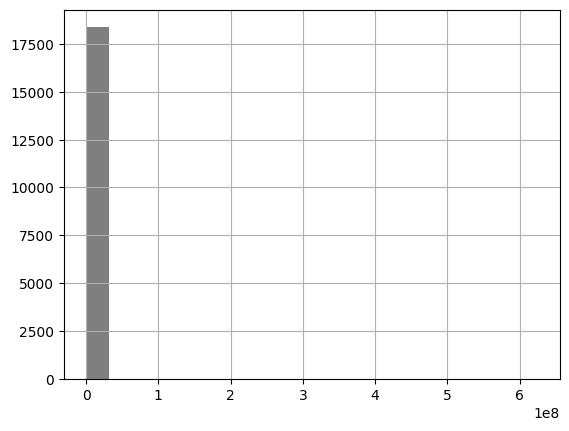

In [77]:
kpi_1920[2].hist(color='k', alpha=0.5, bins=20)